In [1]:
# Import all dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define basic image parameters
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
DATA_DIR = 'datasets/city_landscapes/'

In [3]:
train_image_folder = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

# Load the data
train_data_loader = DataLoader(train_image_folder, batch_size=batch_size, shuffle=True, num_workers=3,
                               pin_memory=True)

In [4]:
# Function for denormalizing image tensors
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [5]:
# Function that shows images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

# Function that shows batch of images
def show_batch(data_loader, nmax=64):
    for images, _ in data_loader:
        show_images(images, nmax)
        break

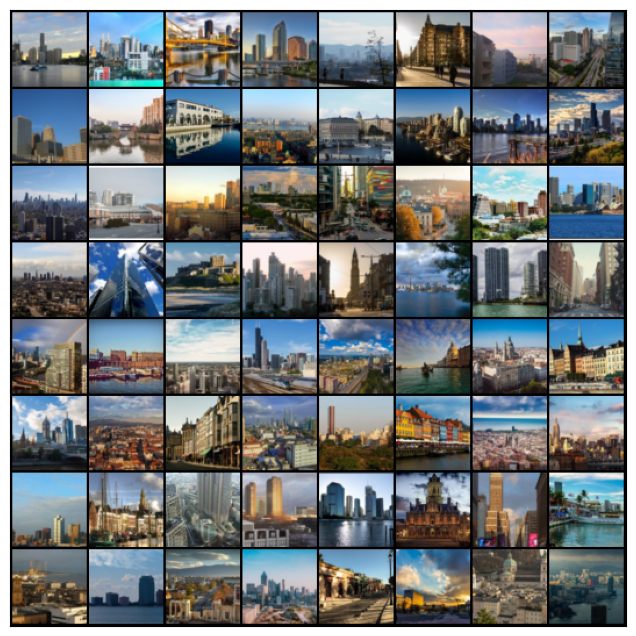

In [6]:
# Show 64 images (1 batch) from training data loader
show_batch(train_data_loader)

In [31]:
# Set up a proper device (in our case - GPU)
def get_default_device():
    
    # GPU if available, else choose CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Move any tensor to chosen device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    # Wrap a dataloader to move data to a device
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
    
    # Yield a batch of data after moving it to device
    def __iter__(self):
        for b in self.data_loader:
            yield to_device(b, self.device)
    
    # Get number of batches
    def __len__(self):
        return len(self.data_loader)

In [8]:
# Set up a device, "cuda" (GPU) in our case
device = get_default_device()
device

device(type='cuda')

In [9]:
# Move our training data loader to our device of use
train_data_loader = DeviceDataLoader(train_data_loader, device)

In [40]:
# Define a Discriminator model
discriminator = nn.Sequential(
    # In: 3 x 64 x 64
    
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 64 x 32 x 32
    
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 128 x 16 x 16
    
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 256 x 8 x 8
    
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 512 x 4 x 4
    
    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # Out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [41]:
# Move a discriminator to a chosen device
discriminator = to_device(discriminator, device)
#discriminator.cuda()

In [42]:
# Generator network will use a latent vector
# In our case it is 128 x 1 x 1 tensor with random numbers.
# It is used as a seed for an image
latent_size = 128

# Define a generator model
generator = nn.Sequential(
    # In: latent_size x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    # Out: 512, 4, 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    # Out: 256, 8, 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    # Out: 128, 16, 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    # Out: 64, 32, 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # Out: 3, 64, 64    
)

torch.Size([128, 3, 64, 64])


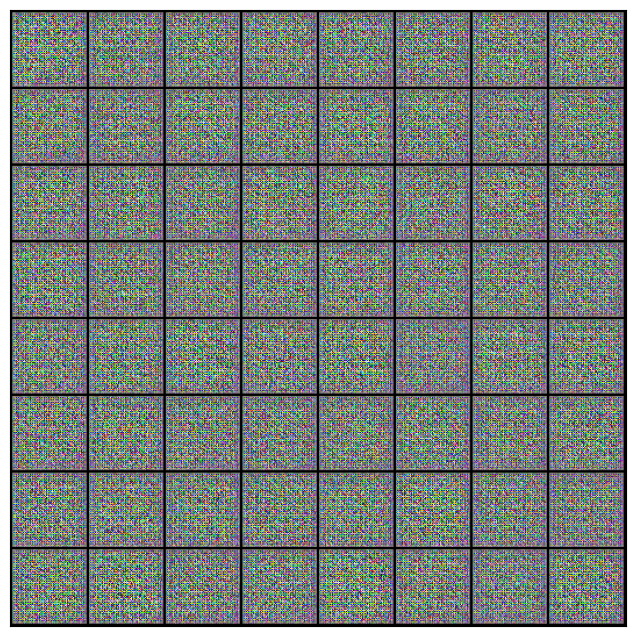

In [43]:
# Generate random images using generator
random_tensor = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(random_tensor)
print(fake_images.shape)
show_images(images=fake_images)

In [44]:
# Move generator to a chosen device
generator = to_device(generator, device)
#generator.cuda()

In [45]:
# Helper function for discriminator training process
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [46]:
# Helper function for generator training process
def train_generator(opt_g):
    
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [17]:
saved_images_directory = 'generated_images'

In [18]:
# Define a helper function for saving an images
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_file_name = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(saved_images_directory, fake_file_name), nrow=8)
    print('Saving', fake_file_name)
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


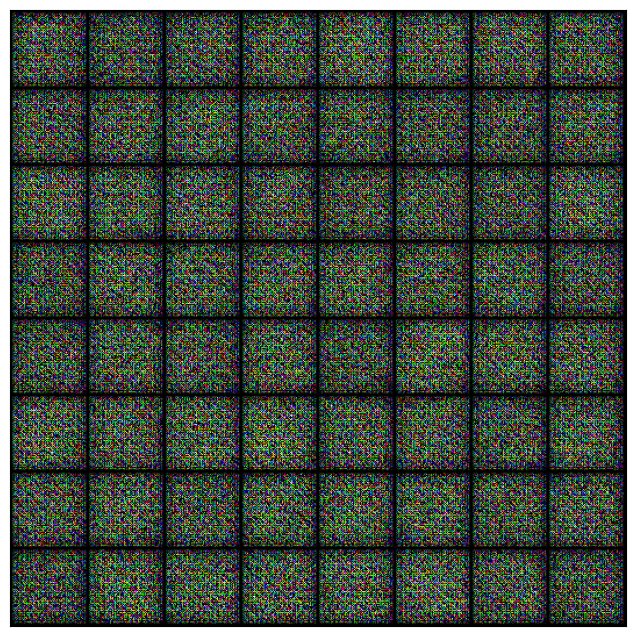

In [47]:
# Test the function
starting_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, starting_latent)

In [48]:
# Helper function for main training loop
def fit(epochs, lr, start_idx=1):
    
    # Release occupied cache memory
    torch.cuda.empty_cache()
    
    # Lists for losses and scores
    losses_generator = []
    losses_discriminator = []
    real_scores = []
    fake_scores = []
    
    # Define optimizers for both models
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_data_loader):
            
            # Train discriminator
            loss_discriminator, real_score, fake_score = train_discriminator(real_images, optimizer_discriminator)
            
            # Train generator
            loss_generator = train_generator(optimizer_generator)
        
        # Record losses and scores
        losses_generator.append(loss_generator)
        losses_discriminator.append(loss_discriminator)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_generator, loss_discriminator, real_score, fake_score
        ))
        
        # Save generated images
        save_samples(epoch + start_idx, starting_latent, show=False)
    
    return losses_generator, losses_discriminator, real_scores, fake_scores

In [21]:
# Set up hyperparameters for our GAN
lr = 0.0002
epochs = 25

In [49]:
# Start and record training process
history = fit(epochs=epochs, lr=lr)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.1793, loss_d: 0.5620, real_score: 0.8537, fake_score: 0.2120
Saving generated-images-0001.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 8.0937, loss_d: 0.4624, real_score: 0.8492, fake_score: 0.2152
Saving generated-images-0002.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 8.1438, loss_d: 0.1502, real_score: 0.9013, fake_score: 0.0139
Saving generated-images-0003.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 11.3611, loss_d: 0.2680, real_score: 0.9503, fake_score: 0.1852
Saving generated-images-0004.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 14.8082, loss_d: 0.0422, real_score: 0.9596, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 15.1279, loss_d: 0.1012, real_score: 0.9188, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 15.3910, loss_d: 2.2441, real_score: 0.9950, fake_score: 0.8833
Saving generated-images-0007.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 12.6677, loss_d: 0.1428, real_score: 0.8851, fake_score: 0.0000
Saving generated-images-0008.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 15.0950, loss_d: 0.2744, real_score: 0.8261, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.2334, loss_d: 0.3027, real_score: 0.8406, fake_score: 0.0432
Saving generated-images-0010.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.0356, loss_d: 0.1184, real_score: 0.9876, fake_score: 0.0983
Saving generated-images-0011.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.8477, loss_d: 0.0567, real_score: 0.9923, fake_score: 0.0475
Saving generated-images-0012.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.8926, loss_d: 0.1242, real_score: 0.9381, fake_score: 0.0559
Saving generated-images-0013.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 8.5441, loss_d: 0.7019, real_score: 0.9577, fake_score: 0.4603
Saving generated-images-0014.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 8.6046, loss_d: 1.3988, real_score: 0.3664, fake_score: 0.0035
Saving generated-images-0015.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.6797, loss_d: 0.4226, real_score: 0.9583, fake_score: 0.3008
Saving generated-images-0016.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.7517, loss_d: 0.2293, real_score: 0.9075, fake_score: 0.1177
Saving generated-images-0017.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 5.6581, loss_d: 0.1956, real_score: 0.9137, fake_score: 0.0929
Saving generated-images-0018.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.6544, loss_d: 1.5444, real_score: 0.9241, fake_score: 0.6589
Saving generated-images-0019.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 2.7815, loss_d: 1.2614, real_score: 0.5488, fake_score: 0.4354
Saving generated-images-0020.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 1.3679, loss_d: 0.4793, real_score: 0.7490, fake_score: 0.1395
Saving generated-images-0021.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.9069, loss_d: 0.6682, real_score: 0.5736, fake_score: 0.0422
Saving generated-images-0022.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 3.7173, loss_d: 0.8621, real_score: 0.8560, fake_score: 0.4744
Saving generated-images-0023.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.7181, loss_d: 1.3282, real_score: 0.8395, fake_score: 0.6525
Saving generated-images-0024.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 1.7500, loss_d: 0.8215, real_score: 0.5361, fake_score: 0.1281
Saving generated-images-0025.png


In [51]:
# Save losses and scores
losses_g, losses_d, real_scores, fake_scores = history

In [52]:
# Save the model checkpoints
torch.save(generator.state_dict(), "checkpoints/generator.pth")
torch.save(discriminator.state_dict(), "checkpoints/discriminator.pth")